In [16]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

from prophet import Prophet
import kaggle
import os

def download_kaggle_dataset(kaggle_dataset: str ="pratyushakar/rossmann-store-sales") -> None:
    api = kaggle.api
    print(api.get_config_value('username'))
    kaggle.api.dataset_download_files(kaggle_dataset, path="./", unzip=True, quiet=False)
    
def prep_store_data(df: pd.DataFrame, store_id: int = 4, store_open: int = 1) -> pd.DataFrame:
    df['Date'] = pd.to_datetime(df['Date'])
    df.rename(columns= {'Date': 'ds', 'Sales': 'y'}, inplace=True)
    df_store = df[
        (df['Store'] == store_id) &\
        (df['Open'] == store_open)
    ].reset_index(drop=True)
    return df_store.sort_values('ds', ascending=True)   
    
def plot_store_data(df: pd.DataFrame) -> None:
    plt.rcParams.update({'font.size': 22})
    fig, ax = plt.subplots(figsize=(20,10))
    df.plot(x='ds', y='y', ax=ax)
    ax.set_xlabel('Date')
    ax.set_ylabel('Volume')
    ax.legend(['Truth'])
    current_ytick_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_ytick_values])
    plt.savefig('store_data.png')

def train_predict(
    df: pd.DataFrame, 
    train_fraction: float, 
    seasonality: dict
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, int]:
    
    # grab split data
    train_index = int(train_fraction*df.shape[0])
    df_train = df.copy().iloc[0:train_index]
    df_test = df.copy().iloc[train_index:]

    #create Prophet model
    model=Prophet(
        yearly_seasonality=seasonality['yearly'],
        weekly_seasonality=seasonality['weekly'],
        daily_seasonality=seasonality['daily'],
        interval_width = 0.95
    )

    # train and predict
    model.fit(df_train)
    predicted = model.predict(df_test)
    return predicted, df_train, df_test, train_index


def plot_forecast(df_train: pd.DataFrame, df_test: pd.DataFrame, predicted: pd.DataFrame) -> None:
    fig, ax = plt.subplots(figsize=(20,10))
    df_test.plot(
        x='ds', 
        y='y', 
        ax=ax, 
        label='Truth', 
        linewidth=1, 
        markersize=5, 
        color='tab:blue',
        alpha=0.9, 
        marker='o'
    )
    predicted.plot(
        x='ds', 
        y='yhat', 
        ax=ax, 
        label='Prediction', 
        linewidth=2, 
        markersize=5, 
        color='k'
    )
    ax.fill_between(
        x=predicted['ds'], 
        y1=predicted['yhat_upper'], 
        y2=predicted['yhat_lower'], 
        alpha=0.1, 
        color='k'
    )
    df_train.iloc[train_index-100:].plot(
        x='ds', 
        y='y', 
        ax=ax, 
        color='tab:blue', 
        label='_nolegend_', 
        alpha=0.5, 
        marker='o'
    )
    current_ytick_values = plt.gca().get_yticks()
    plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_ytick_values])
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    plt.savefig('store_data_forecast.png')       

In [2]:
# If data present, read it in
file_path = 'rossman_store_data/train.csv'
if os.path.exists(file_path):
    logging.info('Dataset found, reading into pandas dataframe.')
    df = pd.read_csv(file_path)
else:
    logging.info('Dataset not found, downloading ...')
    download_kaggle_dataset()

/var/folders/xk/jd8rqnqx039d6l59bvv6j0l80000gn/T/ipykernel_3371/3728763592.py:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [3]:
df = prep_store_data(df)

In [9]:
seasonality = {
    'yearly': True,
    'weekly': True,
    'daily': False
}

predicted, df_train, df_test, train_index = train_predict(
    df = df,
    train_fraction = 0.8,
    seasonality=seasonality
)

DEBUG:cmdstanpy:input tempfile: /var/folders/xk/jd8rqnqx039d6l59bvv6j0l80000gn/T/tmpdqg4s9r3/eeju698g.json
DEBUG:cmdstanpy:input tempfile: /var/folders/xk/jd8rqnqx039d6l59bvv6j0l80000gn/T/tmpdqg4s9r3/4cfn3zg2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/opt/homebrew/Caskroom/miniforge/base/envs/mlewp-chapter01/lib/python3.10/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16163', 'data', 'file=/var/folders/xk/jd8rqnqx039d6l59bvv6j0l80000gn/T/tmpdqg4s9r3/eeju698g.json', 'init=/var/folders/xk/jd8rqnqx039d6l59bvv6j0l80000gn/T/tmpdqg4s9r3/4cfn3zg2.json', 'output', 'file=/var/folders/xk/jd8rqnqx039d6l59bvv6j0l80000gn/T/tmpdqg4s9r3/prophet_modeluab9vkhl/prophet_model-20230326144213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:42:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:42:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:

/opt/homebrew/Caskroom/miniforge/base/envs/mlewp-chapter01/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:807: UserWarning: The label '_nolegend_' of <matplotlib.lines.Line2D object at 0x11b63bd00> starts with '_'. It is thus excluded from the legend.
  ax.legend(handles, labels, loc="best", title=title)
/var/folders/xk/jd8rqnqx039d6l59bvv6j0l80000gn/T/ipykernel_3371/371713086.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.0f}'.format(x) for x in current_ytick_values])


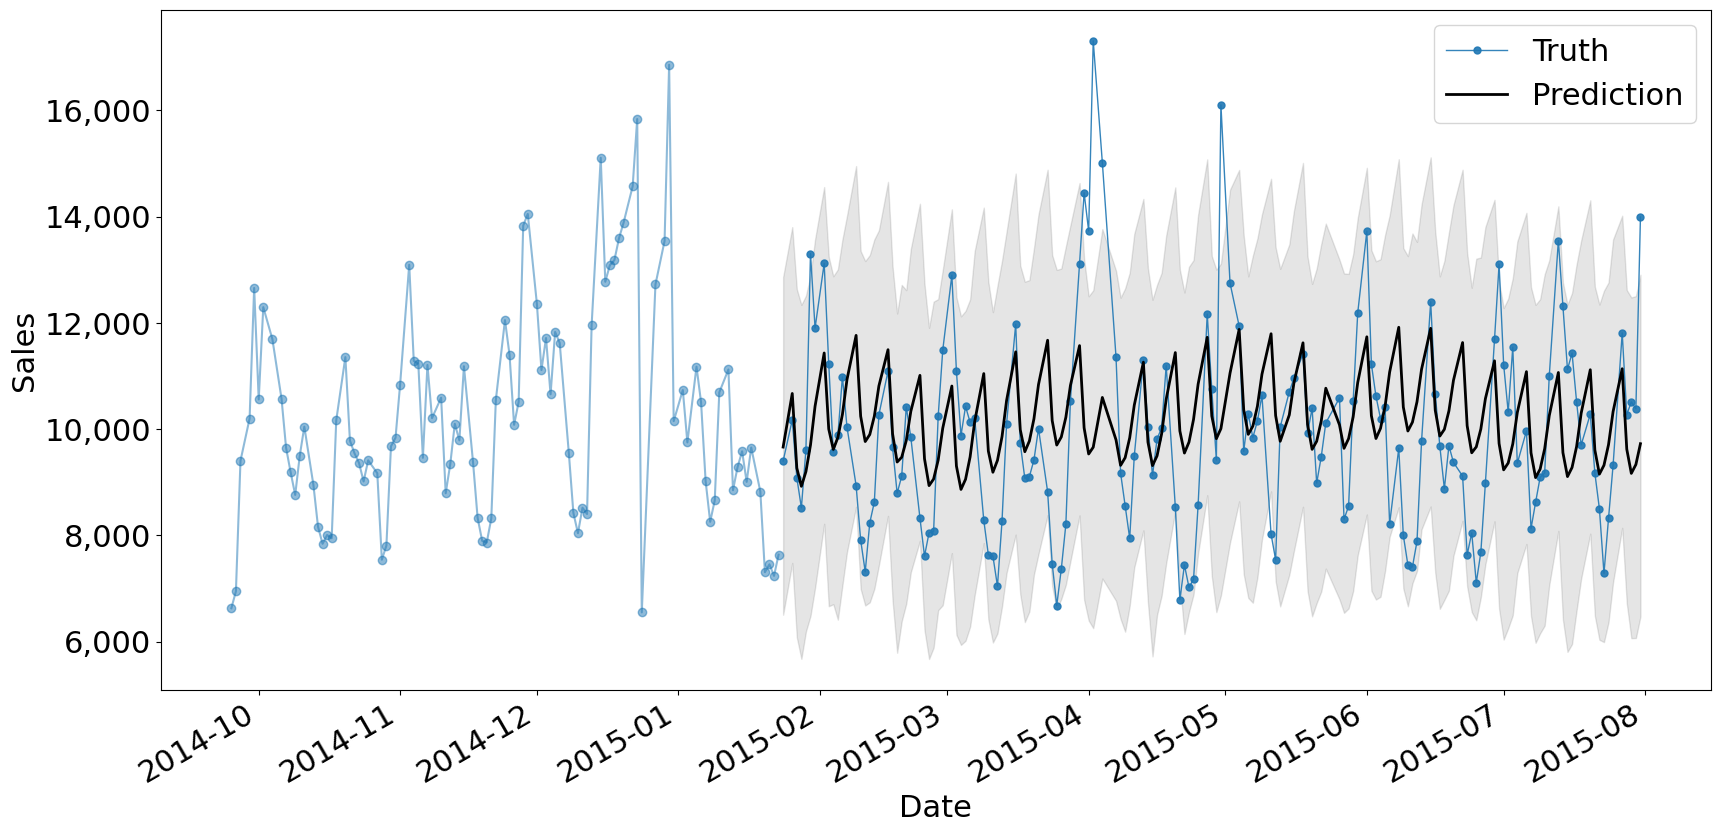

In [17]:
plot_forecast(df_train, df_test, predicted)